# UTS MACHINE LEARNING

Deskripsi Umum:

Tugas kali ini adalah mengerjakan studi kasus analisis data dan clustering menggunakan unsupervised learning dengan langkah-langkah sebagai berikut: 

1. Preprocessing data
- Tangani missing values (imputasi mean/median/modus sesuai jenis data) 
- Normalisasi atau standarisasi data 
- Buat minimal satu fitur baru hasil kombinasi fitur lama 
2. Clustering 
- Terapkan K-Means dan DBSCAN 
- Bandingkan hasil clustering menggunakan: 
    - Silhouette Score 
    - Davies–Bouldin Index 
3. Approximate Nearest Neighbor (ANN) 
- Gunakan Annoy untuk mencari tetangga terdekat dari beberapa query points hasil clustering 
- Tampilkan output berupa: 
    - Index query point 
    - Daftar tetangga terdekat yang ditemukan 
    - Nilai jarak kemiripan

In [1]:
# import libraries
import os
import warnings
from pathlib import Path

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score, davies_bouldin_score 
from annoy import AnnoyIndex 
import matplotlib.pyplot as plt 
import seaborn as sns 
from openpyxl import load_workbook

#  Load Data

Awali dengan melakukan load data dari csv yang disediakan menjadi sebuah dataframe yang dapat diproses

In [2]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

Setelah dimuat, lakukan pemeriksaan awal pada dataset untuk mengetahui:
- Jumlah baris
- Jumlah fitur (kolom)
- Tipe data fitur

Pada dataset yang digunakan, diketahui terdapat 1460 sampel dan 80 fitur dengan bermacam tipe data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocessing

Gunakan log untuk menyimpan hasil dari tiap langkah preprocessing ke dalam sheet pada file excel

In [6]:
output_path = "preprocessing_log.xlsx"

def log_step(df_step, filename, sheet_name, description):
    # Sisipkan baris deskripsi di atas header
    desc_row = pd.DataFrame([[description] + [""] * (len(df_step.columns) - 1)], columns=df_step.columns)
    df_final = pd.concat([desc_row, df_step], ignore_index=True)

    file_exists = Path(filename).is_file()

    if file_exists:
        with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            df_final.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        with pd.ExcelWriter(filename, engine="openpyxl") as writer:
            df_final.to_excel(writer, sheet_name=sheet_name, index=False)

log_step(df, output_path, "raw data", "RAW DATA")

## Handle Missing Value

Pada preprocessing data, langkah pertama adalah menghapus atau melakukan impute pada data-data kosong(null)

Cari terlebih dahulu kolom yang memiliki null value untuk kemudian diambil langkah lebih lanjut

In [7]:
missing_values = df.isna().sum()
# tampilkan fitur yang memiliki null value saja
print(missing_values[missing_values > 0])

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Terdapat beberapa fitur yang memiliki jumlah null value yang besar jika dibandingkan jumlah data. Maka langkah selanjutnya adalah melakukan eliminasi terhadap fitur yang memiliki lebih dari 60% null value

In [8]:
persentase_null = (df.isna().sum() / len(df)) * 100
# tampilkan fitur dengan persentase null value lebih dari 60%
print(persentase_null[persentase_null > 60])

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [9]:
#Drop Fitur PoolQC, MiscFeature, Alley and Fence
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

log_step(df, output_path, "handle missing value(1)", "Drop pada fitur yang memiliki jumlah baris kosong > 50%")

# Cek kembali daftar kolom dengan nilai null lebih dari 1
missing_values = df.isna().sum()
print(missing_values[missing_values > 0])

LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


Lakukan imputasi pada kolom tersisa yang masih memiliki null value.

### Kategorikal
- Kolom --'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'FireplaceQu', 'GarageCond'-- akan diisi dengan value "None" (berdasarkan data description).
- Kolom lain diisi dengan value yang paling sering muncul

In [10]:
object_columns_df = df.select_dtypes(include=['object'])

missing_values = object_columns_df.isna().sum()
print(missing_values[missing_values > 0])

MasVnrType      872
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


In [11]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
df[columns_None]= df[columns_None].fillna('None')

In [12]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
# Mengisi value dengan value yang paling sering muncul
df[columns_with_lowNA] = df[columns_with_lowNA].fillna(df.mode().iloc[0])

In [13]:
# Cek kembali
object_columns_df = df.select_dtypes(include=['object'])

missing_values = object_columns_df.isna().sum()
print(missing_values[missing_values > 0])

# Pencatatan histori
log_step(df, output_path, "handle missing value(2)", "Imputasi pada kolom kategorikal dengan nilai None atau nilai yang paling sering muncul")

Series([], dtype: int64)


### Numeric

- Kolom -- 'LotFrontage', 'GarageYrBlt'-- akan diisi median
- Kolom lain diisi dengan 0

In [14]:
numerical_columns_df = df.select_dtypes(exclude=['object'])

missing_values = numerical_columns_df.isna().sum()
print(missing_values[missing_values > 0])

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [15]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YrSold']-(df['YrSold']-df['YearBuilt']).median())
df['LotFrontage'] = df['LotFrontage'].fillna(df["LotFrontage"].median())

In [16]:
df= df.fillna(0)

In [17]:
# Cek kembali
numerical_columns_df = df.select_dtypes(exclude=['object'])

missing_values = numerical_columns_df.isna().sum()
print(missing_values[missing_values > 0])

# Pencatatan histori
log_step(df, output_path, "handle missing value(3)", "Imputasi pada kolom numerical dengan nilai median atau 0")

Series([], dtype: int64)


## Encoding

Untuk mempermudah analisis data, proses encoding diperlukan pada kolom yang bertipe data kategorikal

Pertama-tama cek apa saja kolom kategorikal yang dapat di-encoding

In [18]:
df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

Kelompokkan fitur bergantung pada metode encoding yang paling sesuai berdasarkan value pada fitur tersebut.
- Ordinal Encoding:
- One Hot Encoding: 

### Ordinal Encoding

In [19]:
# Membuat pemetaan untuk ordinal encoding
qual_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
qual_map_na = {'None': 0, **qual_map}
lotshape_map = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
landslope_map = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
bsmtexposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmtfintype_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
garagefinish_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
paveddrive_map = {'N': 0, 'P': 1, 'Y': 2}
utilities_map = {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}
functional_map = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
electrical_map = {'FuseP': 0, 'FuseF': 1, 'FuseA': 2, 'Mix': 3, 'SBrkr': 4}
centralair_map = {'N': 0, 'Y':1}


# Menerapkan Pemetaan ke DataFrame

df['LotShape'] = df['LotShape'].map(lotshape_map)
df['LandSlope'] = df['LandSlope'].map(landslope_map)
df['ExterQual'] = df['ExterQual'].map(qual_map)
df['ExterCond'] = df['ExterCond'].map(qual_map)
df['BsmtQual'] = df['BsmtQual'].map(qual_map_na)
df['BsmtCond'] = df['BsmtCond'].map(qual_map_na)
df['BsmtExposure'] = df['BsmtExposure'].map(bsmtexposure_map)
df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmtfintype_map)
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmtfintype_map)
df['HeatingQC'] = df['HeatingQC'].map(qual_map)
df['KitchenQual'] = df['KitchenQual'].map(qual_map)
df['FireplaceQu'] = df['FireplaceQu'].map(qual_map_na)
df['GarageFinish'] = df['GarageFinish'].map(garagefinish_map)
df['GarageQual'] = df['GarageQual'].map(qual_map_na)
df['GarageCond'] = df['GarageCond'].map(qual_map_na)
df['PavedDrive'] = df['PavedDrive'].map(paveddrive_map)
df['Utilities'] = df['Utilities'].map(utilities_map)
df['Functional'] = df['Functional'].map(functional_map)
df['Electrical'] = df['Electrical'].map(electrical_map)
df['CentralAir'] = df['CentralAir'].map(centralair_map)

In [20]:
# Pencatatan histori
log_step(df, output_path, "encoding(1)", "Melakukan ordinal encoding untuk fitur-fitur yang sesuai")

# Cek hasil encoding
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,3,Lvl,3,Inside,0,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,3,Lvl,3,FR2,0,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,2,Lvl,3,Inside,0,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,2,Lvl,3,Corner,0,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,2,Lvl,3,FR2,0,...,0,0,0,0,0,12,2008,WD,Normal,250000


### One-Hot Encoding

In [21]:
nominal_column = [
    'MSZoning', 'Street', 'LandContour', 'LotConfig', 'BldgType', 
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'MasVnrType', 'Foundation', 'Heating', 'GarageType', 
    'SaleType', 'SaleCondition', 'Condition1', 'Condition2', 'Neighborhood', 
    'MSSubClass'
]

df = pd.get_dummies(df, columns=nominal_column, drop_first=True)

In [22]:
# Pencatatan histori
log_step(df, output_path, "encoding(2)", "Melakukan One-Hot encoding untuk fitur-fitur yang sesuai")

df.select_dtypes(include='object').columns
df.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,3,3,0,7,5,2003,2003,196.0,...,True,False,False,False,False,False,False,False,False,False
2,80.0,9600,3,3,0,6,8,1976,1976,0.0,...,False,False,False,False,False,False,False,False,False,False
3,68.0,11250,2,3,0,7,5,2001,2002,162.0,...,True,False,False,False,False,False,False,False,False,False
4,60.0,9550,2,3,0,7,5,1915,1970,0.0,...,False,True,False,False,False,False,False,False,False,False
5,84.0,14260,2,3,0,8,5,2000,2000,350.0,...,True,False,False,False,False,False,False,False,False,False


## Create Features

Penambahan fitur TotalArea dari GrLivArea + TotalBsmSF

In [23]:
df['TotalArea'] = df['GrLivArea'] + df['TotalBsmtSF']

In [24]:
# Pencatatan histori
log_step(df, output_path, "feature engineering", "Menambahkan fitur baru dari fitur lama yang ada")
df.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,TotalArea
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,3,3,0,7,5,2003,2003,196.0,...,False,False,False,False,False,False,False,False,False,2566
2,80.0,9600,3,3,0,6,8,1976,1976,0.0,...,False,False,False,False,False,False,False,False,False,2524
3,68.0,11250,2,3,0,7,5,2001,2002,162.0,...,False,False,False,False,False,False,False,False,False,2706
4,60.0,9550,2,3,0,7,5,1915,1970,0.0,...,True,False,False,False,False,False,False,False,False,2473
5,84.0,14260,2,3,0,8,5,2000,2000,350.0,...,False,False,False,False,False,False,False,False,False,3343


## Normalisasi

In [25]:
# Melakukan normalisasi selain kolom one-hot
encoded_prefixes = tuple(nominal_column)
numeric_columns = [col for col in df.columns if not col.startswith(encoded_prefixes)]

# inisialisasi scaler
scaler = StandardScaler()

X_scaled = df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [26]:
# Pencatatan histori
log_step(df, output_path, "normalisasi", "Melakukan normalisasi data kecuali data one-hot encode")
df.head()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,TotalArea
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.701291,0.02618,-0.225716,0.651479,-0.517200,1.050994,0.878668,0.514104,...,False,False,False,False,False,False,False,False,False,-0.008372
2,0.460320,-0.091886,0.701291,0.02618,-0.225716,-0.071836,2.179628,0.156734,-0.429577,-0.570750,...,False,False,False,False,False,False,False,False,False,-0.059386
3,-0.084636,0.073480,-1.016637,0.02618,-0.225716,0.651479,-0.517200,0.984752,0.830215,0.325915,...,False,False,False,False,False,False,False,False,False,0.161672
4,-0.447940,-0.096897,-1.016637,0.02618,-0.225716,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,...,True,False,False,False,False,False,False,False,False,-0.121330
5,0.641972,0.375148,-1.016637,0.02618,-0.225716,1.374795,-0.517200,0.951632,0.733308,1.366489,...,False,False,False,False,False,False,False,False,False,0.935372


In [27]:
output_path = "data_cleaned.xlsx"
log_step(df, output_path, "Sheet 1", "")

In [28]:
df.to_csv('data_cleaned.csv', index=False, sep=',', encoding='utf-8')

# Clustering

In [29]:
features = [
    'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea',
    'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
    'TotalBsmtSF', 'GarageArea', 'TotRmsAbvGrd'
]

selected_prefixes = tuple(features)

selected_columns = [
    col for col in df.columns 
    if any(col == f or col.startswith(f + '_') for f in features)
]

# subset dataframe
X_processed = df[features]

## K-means

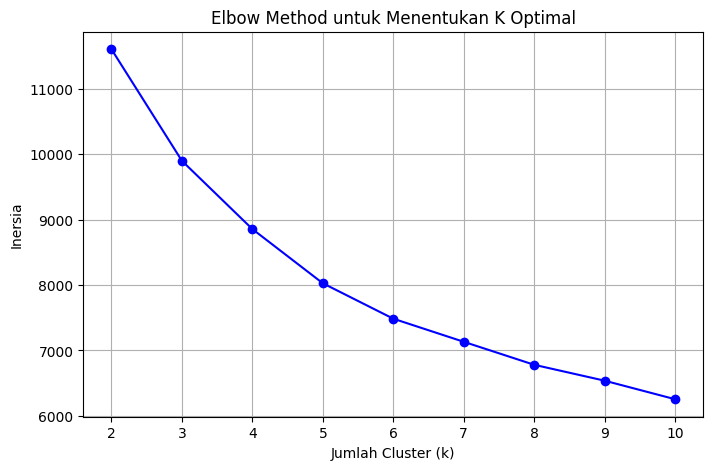

In [30]:
# Menentukan jumlah cluster optimal dengan Elbow Method
inertia = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

# Membuat plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o', color='b')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inersia')
plt.grid(True)
plt.show()
plt.close()

In [31]:
# Berdasarkan plot elbow, kita pilih k=4 sebagai titik siku
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)

# Menghitung Silhouette Score untuk K-Means
kmeans_silhouette = silhouette_score(X_processed, kmeans_labels)

# Menghitung Davies Bouldin Score untuk DBSCAN
kmeans_davies_bouldin = davies_bouldin_score(X_processed, kmeans_labels)

## DBSCAN

In [32]:
dbscan = DBSCAN(eps=6, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_processed)

# Menghitung Silhouette Score untuk DBSCAN
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_processed, dbscan_labels)
else:
    dbscan_silhouette = -1

# Menghitung Davies Bouldin Score untuk DBSCAN
dbscan_davies_bouldin = davies_bouldin_score(X_processed, dbscan_labels)

## Evaluasi

In [33]:
# --- Menampilkan Hasil Perbandingan ---
print(f"Silhouette Score K-Means (k={k_optimal}): {kmeans_silhouette:.4f}")
print(f"Silhouette Score DBSCAN: {dbscan_silhouette:.4f}")

if kmeans_silhouette > dbscan_silhouette:
    print("\nBerdasarkan Silhouette Score, K-Means memberikan hasil clustering yang lebih baik.")
else:
    print("\nBerdasarkan Silhouette Score, DBSCAN memberikan hasil clustering yang lebih baik.")

Silhouette Score K-Means (k=3): 0.2986
Silhouette Score DBSCAN: 0.7217

Berdasarkan Silhouette Score, DBSCAN memberikan hasil clustering yang lebih baik.


In [34]:
# --- Menampilkan Hasil Perbandingan ---
print(f"Davies Bouldin Score K-Means (k={k_optimal}): {kmeans_davies_bouldin:.4f}")
print(f"Davies Bouldin Score DBSCAN: {dbscan_davies_bouldin:.4f}")

if kmeans_davies_bouldin < dbscan_davies_bouldin:
    print("\nBerdasarkan Davies Bouldin Score, K-Means memberikan hasil clustering yang lebih baik.")
else:
    print("\nBerdasarkan Davies Bouldin Score, DBSCAN memberikan hasil clustering yang lebih baik.")

Davies Bouldin Score K-Means (k=3): 1.2112
Davies Bouldin Score DBSCAN: 0.1962

Berdasarkan Davies Bouldin Score, DBSCAN memberikan hasil clustering yang lebih baik.


## Visualisasi Clustering

In [35]:
# Menggunakan PCA untuk mereduksi data menjadi 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Membuat DataFrame baru untuk hasil visualisasi
df_results = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_results['kmeans_cluster'] = kmeans_labels
df_results['dbscan_cluster'] = dbscan_labels

In [36]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
print(loadings)

                   PC1       PC2
OverallQual   0.394256 -0.182398
OverallCond  -0.110123  0.115459
YearBuilt     0.290241 -0.369584
GrLivArea     0.390963  0.271652
FullBath      0.365814  0.115612
BedroomAbvGr  0.179092  0.521953
KitchenAbvGr -0.001336  0.392926
KitchenQual   0.332144 -0.255352
TotalBsmtSF   0.307647 -0.165902
GarageArea    0.335122 -0.168504
TotRmsAbvGrd  0.334924  0.426263


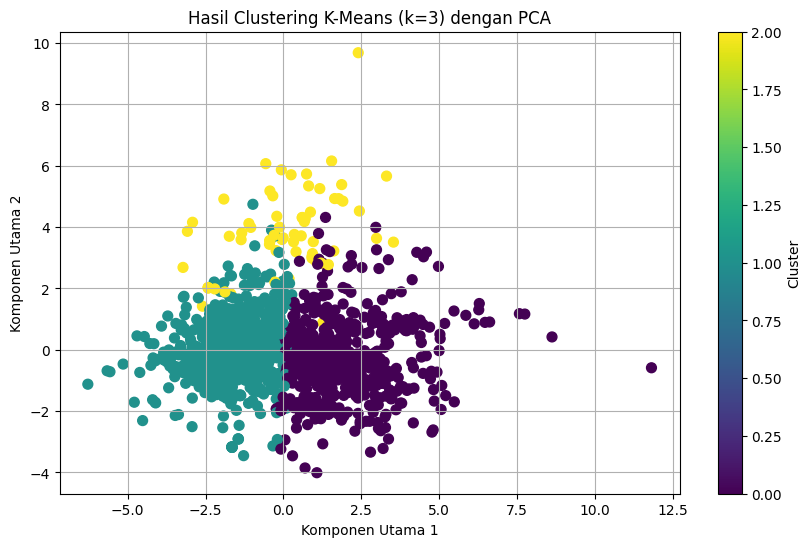

In [37]:
# Visualisasi K-Means
plt.figure(figsize=(10, 6))
plt.scatter(df_results['PCA1'], df_results['PCA2'], c=df_results['kmeans_cluster'], cmap='viridis', marker='o', s=50)
plt.title(f'Hasil Clustering K-Means (k={k_optimal}) dengan PCA')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
plt.close()

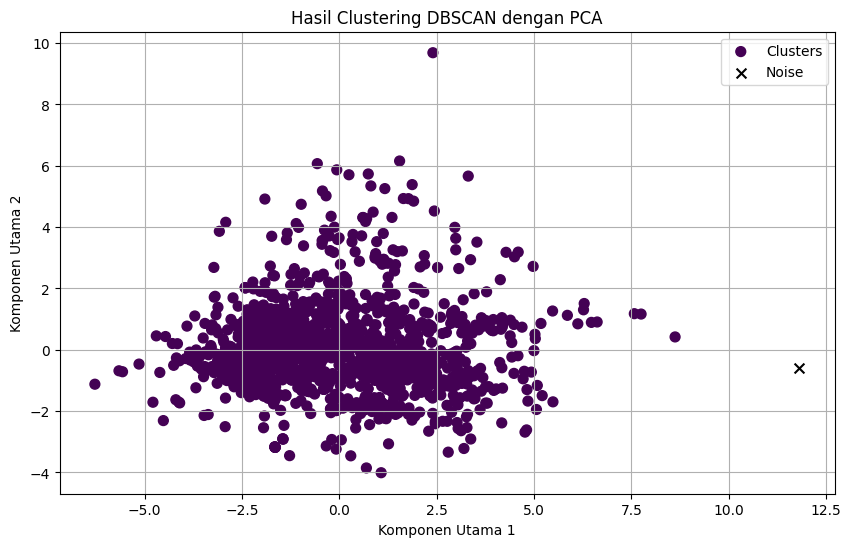

In [38]:
# Visualisasi DBSCAN
plt.figure(figsize=(10, 6))
noise_mask = df_results['dbscan_cluster'] == -1
# Plot titik-titik yang bukan noise
plt.scatter(df_results.loc[~noise_mask, 'PCA1'], df_results.loc[~noise_mask, 'PCA2'], c=df_results.loc[~noise_mask, 'dbscan_cluster'], cmap='viridis', marker='o', s=50, label='Clusters')
# Plot titik-titik noise
plt.scatter(df_results.loc[noise_mask, 'PCA1'], df_results.loc[noise_mask, 'PCA2'], c='black', marker='x', s=50, label='Noise')
plt.title('Hasil Clustering DBSCAN dengan PCA')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# Annoy

In [39]:
from annoy import AnnoyIndex
import time

X = X_pca.astype('float32')
f = X.shape[1]

t = AnnoyIndex(f, 'euclidean')

for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(10)

query_idx = 42
query = X[query_idx]

start = time.time()
neighbors = t.get_nns_by_vector(query, 5)  # ambil 5 tetangga terdekat
time_annoy = (time.time() - start) * 1000  # dalam ms

# --- Hitung jarak aktual untuk tiap tetangga ---
distances = [np.linalg.norm(X[n] - query) for n in neighbors]

# --- Cetak hasil ---
print(f"Query Point Index: {query_idx}")
print(f"Cluster (KMeans) Query Point: {kmeans_labels[query_idx]}")
print(f"Waktu pencarian Annoy: {time_annoy:.4f} ms\n")

print("Nearest Neighbors and Distances:")
for n, d in zip(neighbors, distances):
    print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {kmeans_labels[n]}")

Query Point Index: 42
Cluster (KMeans) Query Point: 1
Waktu pencarian Annoy: 0.1256 ms

Nearest Neighbors and Distances:
Neighbor Index: 42 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 376 | Distance: 0.0405 | Cluster (KMeans): 1
Neighbor Index: 880 | Distance: 0.1575 | Cluster (KMeans): 1
Neighbor Index: 1452 | Distance: 0.1588 | Cluster (KMeans): 1
Neighbor Index: 954 | Distance: 0.1640 | Cluster (KMeans): 1


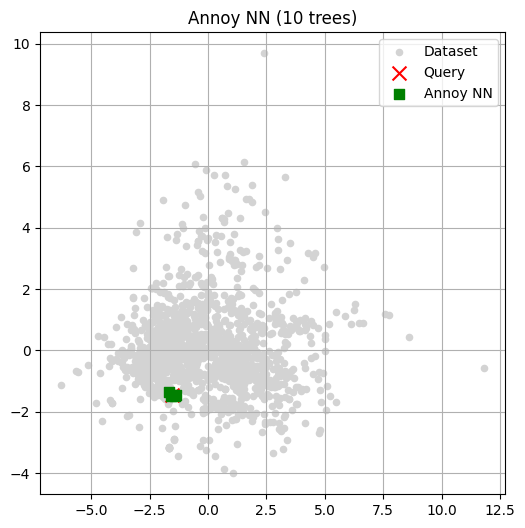

In [40]:
# Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Annoy NN ditandai hijau
plt.scatter(X[neighbors,0], X[neighbors,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Annoy NN (10 trees)")
plt.grid(True)
plt.show()

# Kesimpulan

1. Untuk dataset house prices dengan mempertimbangkan fitur-fitur untuk melihat rumah dengan karakteristik yang mirip atau hampir sama, dapat disimpulkan bahwa penggunaan metode DBSCAN dalam clustering tampak lebih baik dari kedua scoring; shilouette dan davies bouldin.
2. Dapat dilihat bahwa metode DBSCAN memiliki skor metrik terbaik baik pada silhouette atau davies bouldin

Silhouette Score K-Means (k=3): 0.2986

Silhouette Score DBSCAN: 0.7217

Davies Bouldin Score K-Means (k=3): 1.2112

Davies Bouldin Score DBSCAN: 0.1962

3. Hasil query annoy menunjukkan bahwa neighbor berada dalam kluster yang sama karena pembagian ruang berdasarkan metode jarak euclidean menghasilkan grup lokal yang konsisten